### **In our example we will be using approximately 10-15 hours of training data.**.


In [ ]:
pip install transformers datasets soundfile speechbrain==0.5.16 accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410

Finally, don’t forget to log in to your Hugging Face account so that you could upload and share your model with the community:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

**The dataset**

For this example we’ll take the Dutch (nl) language subset of the VoxPopuli dataset. VoxPopuli is a large-scale multilingual speech corpus consisting of data sourced from 2009-2020 European Parliament event recordings. It contains labelled audio-transcription data for 15 European languages. While we will be using the Dutch language subset, feel free to pick another subset.

This is an automated speech recognition (ASR) dataset, so, as mentioned before, it is not the most suitable option for training TTS models. However, it will be good enough for this exercise.

Let’s load the data:

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("facebook/voxpopuli", "nl", split="train")

# Take a random subset of 1/4th of the dataset
subset_size = len(dataset) // 4
subset = dataset.shuffle(seed=42).select(range(subset_size))

# Verify the subset size
print(f"Original dataset size: {len(dataset)}")
print(f"Subset dataset size: {len(subset)}")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for facebook/voxpopuli contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/voxpopuli.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset=subset

In [ ]:
from datasets import Audio

In [ ]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

**Preprocessing the data**

Let’s begin by defining the model checkpoint to use and loading the appropriate processor that contains both tokenizer, and feature extractor that we will need to prepare the data for training:

In [ ]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

In [ ]:
tokenizer = processor.tokenizer

In [ ]:
dataset[0]

{'audio_id': '20150909-0900-PLENARY-13-nl_20150909-19:06:12_8',
 'language': 9,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/cac21bd7005c9b433023b8d1f218fd557c2edfc73318268bcf8d913a8a0abd78/train_part_3/20150909-0900-PLENARY-13-nl_20150909-19:06:12_8.wav',
  'array': array([0.00045776, 0.009552  , 0.01150513, ..., 0.01168823, 0.00579834,
         0.00259399]),
  'sampling_rate': 16000},
 'raw_text': 'Dat wil ik u vooral meegeven, en vooral de vraag hoe staat het met de implementatie en de controle, een dubbele controle, gezien het verleden.',
 'normalized_text': 'dat wil ik u vooral meegeven en vooral de vraag hoe staat het met de implementatie en de controle een dubbele controle gezien het verleden.',
 'gender': 'male',
 'speaker_id': '4507',
 'is_gold_transcript': True,
 'accent': 'None'}

In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/5242 [00:00<?, ? examples/s]

Now you have two sets of characters: one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. To identify any unsupported characters in the dataset, you can take the difference between these two sets. The resulting set will contain the characters that are in the dataset but not in the tokenizer.

In [ ]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'è', 'ë', 'í', 'ï', 'ö', 'ü'}

In [ ]:
replacements = [
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/5242 [00:00<?, ? examples/s]

**Speakers**

The VoxPopuli dataset includes speech from multiple speakers, but how many speakers are represented in the dataset? To determine this, we can count the number of unique speakers and the number of examples each speaker contributes to the dataset. With a total of 20,968 examples in the dataset, this information will give us a better understanding of the distribution of speakers and examples in the data.

In [ ]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

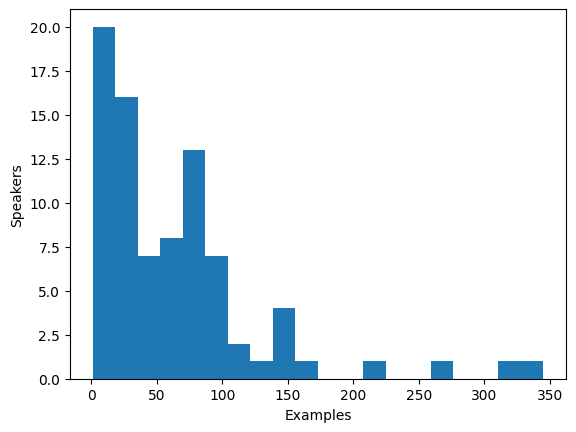

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

The histogram reveals that approximately one-third of the speakers in the dataset have fewer than 100 examples, while around ten speakers have more than 500 examples. To improve training efficiency and balance the dataset, we can limit the data to speakers with between 100 and 400 examples.

In [ ]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/5242 [00:00<?, ? examples/s]

In [ ]:
len(set(dataset["speaker_id"]))

14

In [ ]:
len(dataset)

2442

In [ ]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

It’s important to note that the speechbrain/spkrec-xvect-voxceleb model was trained on English speech from the VoxCeleb dataset, whereas the training examples in this guide are in Dutch. While we believe that this model will still generate reasonable speaker embeddings for our Dutch dataset, this assumption may not hold true in all cases.

For optimal results, we would need to train an X-vector model on the target speech first. This will ensure that the model is better able to capture the unique voice characteristics present in the Dutch language. If you’d like to train your own X-vector model, you can use [this script](https://huggingface.co/mechanicalsea/speecht5-vc/blob/main/manifest/utils/prep_cmu_arctic_spkemb.py) as an example.

**Processing the dataset**

Finally, let’s process the data into the format the model expects. Create a prepare_dataset function that takes in a single example and uses the SpeechT5Processor object to tokenize the input text and load the target audio into a log-mel spectrogram. It should also add the speaker embeddings as an additional input.

In [ ]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [ ]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [ ]:
processed_example["speaker_embeddings"].shape

(512,)

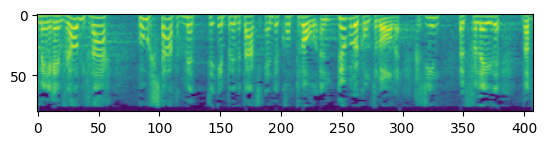

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

Side note: If you find this spectrogram confusing, it may be due to your familiarity with the convention of placing low frequencies at the bottom and high frequencies at the top of a plot. However, when plotting spectrograms as an image using the matplotlib library, the y-axis is flipped and the spectrograms appear upside down.

Now we need to apply the processing function to the entire dataset. This will take between 5 and 10 minutes.

In [ ]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/2442 [00:00<?, ? examples/s]

In [ ]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/2442 [00:00<?, ? examples/s]

2057

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

**Data collator**

In order to combine multiple examples into a batch, you need to define a custom data collator. This collator will pad shorter sequences with padding tokens, ensuring that all examples have the same length. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value instructs the model to ignore that part of the spectrogram when calculating the spectrogram loss.

In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

**Train the model**

Load the pre-trained model from the same checkpoint as you used for loading the processor:

In [ ]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

The use_cache=True option is incompatible with gradient checkpointing. Disable it for training, and re-enable cache for generation to speed-up inference time:

In [ ]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

Define the training arguments. Here we are not computing any evaluation metrics during the training process, we’ll talk about evaluation later in this chapter. Instead, we’ll only look at the loss:

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_nl",  # change to a repo name of your choice
    per_device_train_batch_size=8,  # Reduced batch size to fit in memory
    gradient_accumulation_steps=4,  # Adjusted to balance batch size reduction
    learning_rate=1e-4,  # Slightly increased learning rate for faster convergence
    warmup_steps=200,  # Reduced warmup steps
    max_steps=1000,  # Reduced total steps to fit session limits
    gradient_checkpointing=True,
    fp16=True,  # Keep mixed precision training for efficiency
    evaluation_strategy="steps",
    per_device_eval_batch_size=4,
    save_steps=500,  # Reduced save frequency to avoid overhead
    eval_steps=500,  # Matching eval frequency with save frequency
    logging_steps=50,  # Adjusted logging frequency
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=False,  # Disable pushing to hub to avoid authorization issues
)

# Make sure to authenticate with Hugging Face Hub if push_to_hub is True


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

max_steps is given, it will override any value given in num_train_epochs


And with that, we’re ready to start training! Training will take several hours. Depending on your GPU, it is possible that you will encounter a CUDA “out-of-memory” error when you start training. In this case, you can reduce the per_device_train_batch_size incrementally by factors of 2 and increase gradient_accumulation_steps by 2x to compensate.

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
500,0.496700,0.471976
1000,0.466300,0.460325


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
/usr/local/lib/python3.10/dist-packages/torch/utils/che

TrainOutput(global_step=1000, training_loss=0.5178307609558106, metrics={'train_runtime': 1849.98, 'train_samples_per_second': 17.297, 'train_steps_per_second': 0.541, 'total_flos': 4713456636187200.0, 'train_loss': 0.5178307609558106, 'epoch': 17.24137931034483})

In [ ]:
trainer.push_to_hub()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

events.out.tfevents.1721349276.ed51db07a570.519.0:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/div-face/speecht5_finetuned_voxpopuli_nl/commit/b8b754971ec97d1cb5cd060e7f2b2e7b78555370', commit_message='End of training', commit_description='', oid='b8b754971ec97d1cb5cd060e7f2b2e7b78555370', pr_url=None, pr_revision=None, pr_num=None)

**Inference**

Once you have fine-tuned a model, you can use it for inference! Load the model from the 🤗 Hub (make sure to use your account name in the following code snippet):

In [ ]:
model = SpeechT5ForTextToSpeech.from_pretrained(
    "YOUR-ACCOUNT/speecht5_finetuned_voxpopuli_nl"
)

config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
example = dataset["test"][200]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [ ]:
text = "hallo allemaal, ik praat nederlands. groetjes aan iedereen!"

In [ ]:
inputs = processor(text=text, return_tensors="pt")

Instantiate a vocoder and generate speech:


In [ ]:
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

# Ready to listen to the result?

---



In [ ]:
from IPython.display import Audio

Audio(speech.numpy(), rate=16000)

Obtaining satisfactory results from this model on a new language can be challenging. The quality of the speaker embeddings can be a significant factor. Since SpeechT5 was pre-trained with English x-vectors, it performs best when using English speaker embeddings. If the synthesized speech sounds poor, try using a different speaker embedding.

Increasing the training duration is also likely to enhance the quality of the results. Even so, the speech clearly is Dutch instead of English, and it does capture the voice characteristics of the speaker (compare to the original audio in the example). Another thing to experiment with is the model’s configuration. For example, try using config.reduction_factor = 1 to see if this improves the results.

